# Master Thesis Evaluation Pipeline

## Setup & Configuration

In [1]:
import os
import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats

from arch.bootstrap import MCS
from matplotlib.lines import Line2D
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

from IPython.display import display

# Style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"font.size": 11, "figure.figsize": (10, 6)})
warnings.simplefilter(action="ignore", category=FutureWarning)

# Figures dir (next to notebook; fallback: cwd)
try:
    import ipynbname  # optional
    _NB_DIR = Path(ipynbname.path()).parent
except Exception:
    _NB_DIR = Path.cwd()

FIG_DIR = _NB_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Notebook dir : {_NB_DIR}")
print(f"Figures dir  : {FIG_DIR}")

Notebook dir : /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests
Figures dir  : /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures


# Project paths
Locate repo root and stageB outputs.

In [2]:
def _locate_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(5):
        if (cur / "src").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start.resolve()

PROJECT_ROOT = _locate_repo_root(Path.cwd())
STAGEB_DIR = PROJECT_ROOT / "outputs" / "stageB"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f"Project root : {PROJECT_ROOT}")
print(f"Outputs dir  : {STAGEB_DIR}")

Project root : /Users/jonasschernich/Documents/Masterarbeit/Code
Outputs dir  : /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/stageB


# Model mapping
Model registry used to locate `preds.csv`.

In [3]:
MODEL_MAPPING = {
    "Setup_1": {
        "Extra Trees (S1)": {"path": "extra_trees_without_target", "family": "Trees"},
        "LightGBM (S1)": {"path": "lightgbm_without_target_mac", "family": "Boosting"},
        "Elastic Net (S1)": {"path": "elastic_net_without_target_700", "family": "Linear"},
        "TabPFN (S1)": {"path": "tabpfn_without_target", "family": "Transformers"},
        "SFM (S1)": {"path": "sfm_without_target", "family": "Factor Models"},
        "GPR (S1)": {"path": "gpr_without_target", "family": "Kernel Methods"},
        "SVR (S1)": {"path": "svr_without_target", "family": "Kernel Methods"},
        "Ensemble (S1)": {"path": "ensemble_stacking_without_target", "family": "Ensemble"},
    },
    "Setup_2": {
        "Extra Trees (S2)": {"path": "extra_trees_with_target", "family": "Trees"},
        "LightGBM (S2)": {"path": "lightgbm_with_target_mac", "family": "Boosting"},
        "Elastic Net (S2)": {"path": "elastic_net_with_target_700", "family": "Linear"},
        "TabPFN (S2)": {"path": "tabpfn_with_target", "family": "Transformers"},
        "SFM (S2)": {"path": "sfm_with_target", "family": "Factor Models"},
        "GPR (S2)": {"path": "gpr_with_target", "family": "Kernel Methods"},
        "SVR (S2)": {"path": "svr_with_target", "family": "Kernel Methods"},
        "Ensemble (S2)": {"path": "ensemble_stacking_with_target", "family": "Ensemble"},
    },
    "Setup_3": {
        "Extra Trees (S3)": {"path": "extra_trees_dynamic_fi", "family": "Trees"},
        "LightGBM (S3)": {"path": "lightgbm_dynamic_fi", "family": "Boosting"},
        "Elastic Net (S3)": {"path": "elastic_net_dynamic_fi", "family": "Linear"},
        "TabPFN (S3)": {"path": "tabpfn_dynamic_fi", "family": "Transformers"},
        "SFM (S3)": {"path": "sfm_dynamic_fi", "family": "Factor Models"},
        "GPR (S3)": {"path": "gpr_dynamic_fi", "family": "Kernel Methods"},
        "SVR (S3)": {"path": "svr_dynamic_fi", "family": "Kernel Methods"},
        "Ensemble (S3)": {"path": "ensemble_stacking_dynamic_fi", "family": "Ensemble"},
    },
    "Baselines": {
        "AR(1)": {"path": "baseline_ar1", "family": "Baseline"},
        "RW": {"path": "baseline_rw", "family": "Baseline"},
        "Grand Mean": {"path": "baseline_mean", "family": "Baseline"},
        "Running Mean": {"path": "baseline_ma60", "family": "Baseline"},
    },
}

# Helpers
Loading, metrics, and DM/MCS utilities.

In [4]:
def load_predictions(mapping_dict, stage_dir: Path):
    """
    Loads preds.csv for each model, creates a wide DataFrame,
    and performs hard index deduplication.
    """
    dfs = []
    y_true = None
    meta = {}

    for name, info in mapping_dict.items():
        path = stage_dir / info["path"] / "monthly" / "preds.csv"
        if not path.exists():
            continue

        try:
            df = pd.read_csv(path, parse_dates=["date_t_plus_1"])
            df = df[df["is_active"] == True].copy()
            df = df.set_index("date_t_plus_1").sort_index()

            if df.index.duplicated().any():
                df = df[~df.index.duplicated(keep="first")]

            s_pred = df["y_pred"].rename(name)
            dfs.append(s_pred)

            if y_true is None:
                y = df["y_true"]
                if y.index.duplicated().any():
                    y = y[~y.index.duplicated(keep="first")]
                y_true = y.rename("y_true")

            meta[name] = info
        except Exception as e:
            print(f"Error loading {name}: {e}")

    if not dfs:
        return pd.DataFrame(), {}

    df_final = pd.concat([y_true] + dfs, axis=1)

    if not df_final.index.is_unique:
        print("Note: Deduplicating final dataframe index...")

    df_final = df_final.reset_index()
    df_final = df_final.groupby("date_t_plus_1").first()
    df_final = df_final.sort_index()

    return df_final, meta


def calculate_dm_test_onesided(e_ref, e_comp, h=12):
    common_idx = e_ref.dropna().index.intersection(e_comp.dropna().index)
    if len(common_idx) < 12:
        return 0.0, 1.0
    e1, e2 = e_ref.loc[common_idx], e_comp.loc[common_idx]
    d = (e1**2) - (e2**2)
    res = sm.OLS(d, np.ones(len(d))).fit(cov_type="HAC", cov_kwds={"maxlags": h})
    t_stat = float(res.tvalues.iloc[0])
    p_val = float(1.0 - stats.norm.cdf(t_stat))
    return t_stat, p_val


def rmse_on_df(df, pred_col):
    err = df["y_true"] - df[pred_col]
    return float(np.sqrt((err**2).mean()))


def mae_on_df(df, pred_col):
    err = df["y_true"] - df[pred_col]
    return float(err.abs().mean())


def get_common_df(df, cols):
    out = df[cols].dropna()
    return out if not out.empty else None


def get_mcs_pvalues(losses_df, size=0.10, block_size=12, reps=10000, seed=0):
    if losses_df is None or losses_df.shape[1] < 2 or len(losses_df) < 15:
        return {}
    mcs = MCS(
        losses_df,
        size=size,
        method="R",
        block_size=block_size,
        reps=reps,
        seed=seed
    )
    mcs.compute()
    return mcs.pvalues.iloc[:, 0] if isinstance(mcs.pvalues, pd.DataFrame) else mcs.pvalues


def best_model_on_common(df_common, model_cols):
    rmse_map = {m: rmse_on_df(df_common, m) for m in model_cols}
    return min(rmse_map, key=rmse_map.get), rmse_map


def clean_model_name(model_key):
    mapping = {
        "Extra Tree": "Extra Trees",
        "ET": "Extra Trees",
        "RF": "Random Forest",
        "LGBM": "LightGBM",
        "ElNet": "Elastic Net",
        "Elastic": "Elastic Net",
    }
    for k, v in mapping.items():
        if k in model_key:
            return v
    return model_key

# Load predictions
Build the wide panel and basic integrity checks.

In [5]:
all_mappings = {}
for group in MODEL_MAPPING.values():
    all_mappings.update(group)

df_full, meta_full = load_predictions(all_mappings, STAGEB_DIR)

print("-" * 30)
print(f"Final data shape : {df_full.shape}")
print(f"Index unique?    : {df_full.index.is_unique}")
print("-" * 30)

try:
    test = df_full["y_true"] - df_full.iloc[:, 0]
    print("Check passed: subtraction works without error.")
except Exception as e:
    print(f"Check failed: {e}")

baseline_keys = [k for k in MODEL_MAPPING["Baselines"].keys() if k in df_full.columns]

------------------------------
Final data shape : (166, 29)
Index unique?    : True
------------------------------
Check passed: subtraction works without error.


# Table R1
Strict common sample per setup + one-sided DM vs best + MCS.

In [6]:
def evaluate_setup_strict(setup_name: str, setup_dict: dict, df_data: pd.DataFrame):
    keys = [k for k in setup_dict.keys() if k in df_data.columns]
    if not keys:
        print(f"Skipping {setup_name} (no columns).")
        return None

    df_common = get_common_df(df_data, keys + ["y_true"])
    if df_common is None or len(df_common) < 15:
        print(f"Skipping {setup_name} (not enough common data).")
        return None

    res = []
    for k in keys:
        res.append({"Model": k, "RMSE": rmse_on_df(df_common, k), "MAE": mae_on_df(df_common, k)})

    df_res = pd.DataFrame(res).set_index("Model")
    best_model, _ = best_model_on_common(df_common, keys)

    losses = (df_common["y_true"].values[:, None] - df_common[keys].values) ** 2
    df_losses = pd.DataFrame(losses, columns=keys, index=df_common.index)
    mcs_pvals = get_mcs_pvalues(df_losses, size=0.10, block_size=12)

    final_table = []
    e_best = df_common["y_true"] - df_common[best_model]

    for k in keys:
        if k == best_model:
            dm_sig = "(Best)"
        else:
            e_curr = df_common["y_true"] - df_common[k]
            t, p = calculate_dm_test_onesided(e_curr, e_best, h=12)
            dm_sig = ""
            if (p < 0.05) and (t > 0):
                dm_sig = "***"
            elif (p < 0.10) and (t > 0):
                dm_sig = "*"

        in_mcs = "no"
        if isinstance(mcs_pvals, (pd.Series, dict)):
            val = float(mcs_pvals.get(k, 0.0)) if isinstance(mcs_pvals, dict) else float(mcs_pvals.get(k, 0.0))
            if val > 0.10:
                in_mcs = "YES"

        final_table.append(
            {
                "Model": k,
                "RMSE (Common)": df_res.loc[k, "RMSE"],
                "MAE (Common)": df_res.loc[k, "MAE"],
                "MCS": in_mcs,
            }
        )

    print(f"\n>>> TABLE R1 (Strict common): {setup_name} <<<")
    print(f"Evaluated on N={len(df_common)} common months.")
    display(pd.DataFrame(final_table).style.highlight_min(subset=["RMSE (Common)", "MAE (Common)"], color="lightgreen"))
    return df_common, best_model


evaluate_setup_strict("Setup I (ifo only)", MODEL_MAPPING["Setup_1"], df_full)
evaluate_setup_strict("Setup II (ifo + targets)", MODEL_MAPPING["Setup_2"], df_full)
evaluate_setup_strict("Setup III (dynamic FE)", MODEL_MAPPING["Setup_3"], df_full)


>>> TABLE R1 (Strict common): Setup I (ifo only) <<<
Evaluated on N=166 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,Extra Trees (S1),2.309302,1.396025,YES
1,LightGBM (S1),2.315589,1.441090,YES
2,Elastic Net (S1),2.312581,1.485336,YES
3,TabPFN (S1),2.197633,1.370506,YES
4,SFM (S1),2.409276,1.543917,YES
5,GPR (S1),2.450065,1.482823,YES
6,SVR (S1),2.307209,1.383108,YES
7,Ensemble (S1),2.236282,1.422838,YES



>>> TABLE R1 (Strict common): Setup II (ifo + targets) <<<
Evaluated on N=166 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,Extra Trees (S2),2.127005,0.999824,YES
1,LightGBM (S2),1.697285,0.848321,YES
2,Elastic Net (S2),2.048163,1.233680,no
3,TabPFN (S2),2.049669,1.255102,no
4,SFM (S2),2.317117,1.651083,no
5,GPR (S2),2.522283,1.542992,no
6,SVR (S2),2.461226,1.609330,no
7,Ensemble (S2),1.678841,0.821920,YES



>>> TABLE R1 (Strict common): Setup III (dynamic FE) <<<
Evaluated on N=166 common months.


,Model,RMSE (Common),MAE (Common),MCS
0,Extra Trees (S3),2.305851,1.375678,YES
1,LightGBM (S3),2.370649,1.387490,YES
2,Elastic Net (S3),2.314105,1.365950,YES
3,TabPFN (S3),2.330182,1.438263,YES
4,SFM (S3),2.341151,1.443693,YES
5,GPR (S3),2.350832,1.377002,YES
6,SVR (S3),2.342188,1.374026,YES
7,Ensemble (S3),2.314105,1.365950,YES


(               Extra Trees (S3)  LightGBM (S3)  Elastic Net (S3)  TabPFN (S3)  \
 date_t_plus_1                                                                   
 2011-03-01             0.430915      -0.059244          0.226811     0.417074   
 2011-04-01             0.332354      -0.054402          0.201930     0.351902   
 2011-05-01             0.320623      -0.084256          0.251719     0.559716   
 2011-06-01             0.217585      -0.040662          0.085012     0.321768   
 2011-07-01             0.089889      -0.021055          0.095224     0.183058   
 ...                         ...            ...               ...          ...   
 2024-08-01            -0.207166      -0.198469         -0.087389    -0.046812   
 2024-09-01            -0.322750      -0.078056         -0.059416    -0.113020   
 2024-10-01            -0.223386       0.223764         -0.070539     0.015786   
 2024-11-01            -0.209792       0.164937         -0.071345     0.032405   
 2024-12-01     

# MCS plots
RMSE deltas + MCS membership (strict common sample).

Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/MCS_Setup_I.png


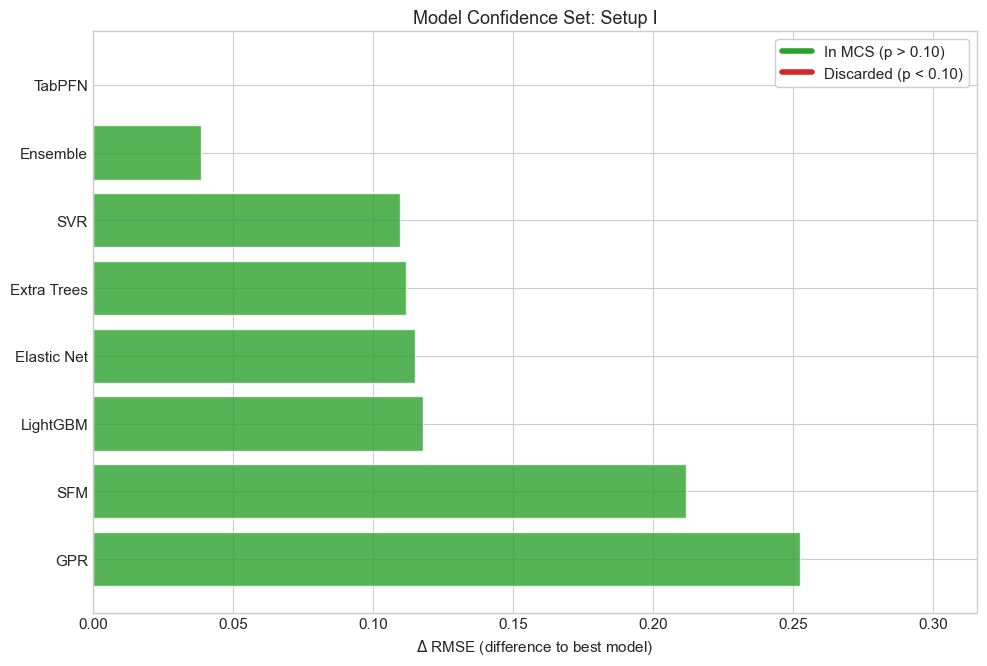

Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/MCS_Setup_II.png


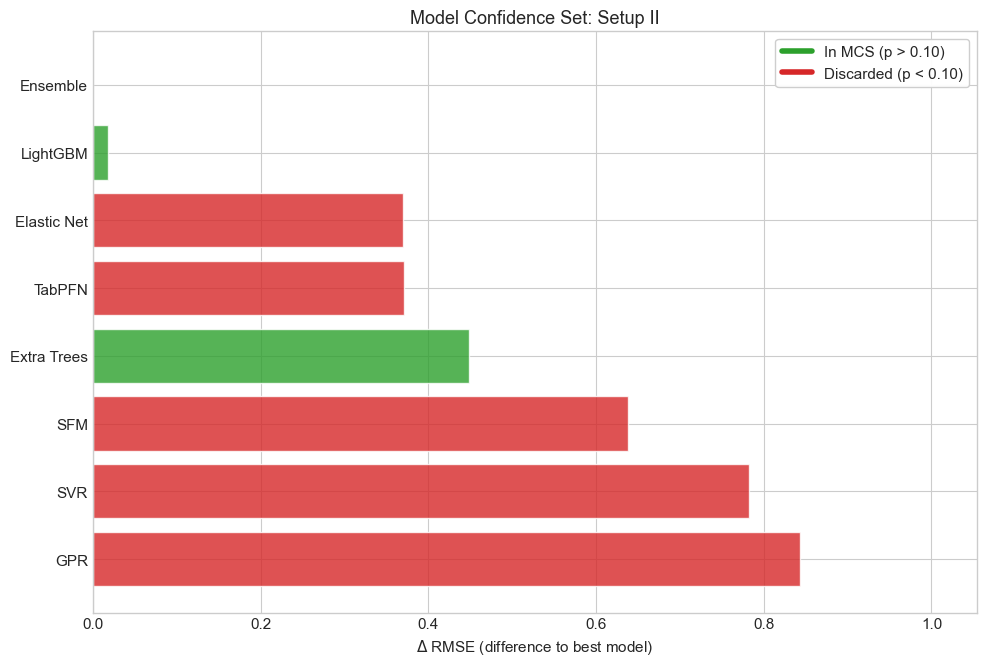

Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/MCS_Setup_III.png


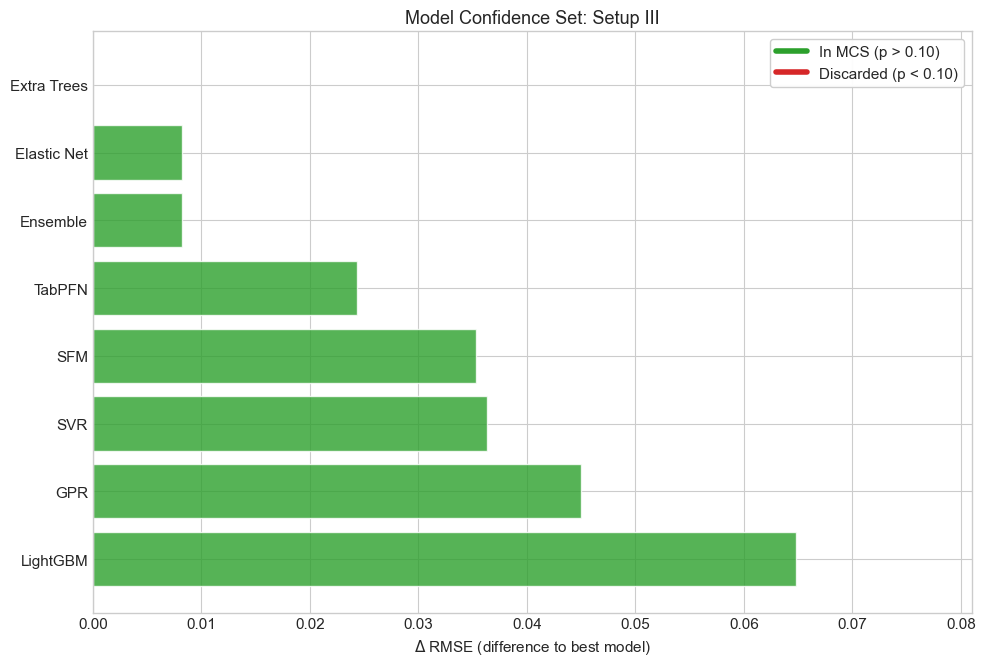

In [7]:
def plot_mcs_bars_strict(setup_name: str, setup_keys, df_data: pd.DataFrame):
    keys = [k for k in setup_keys if k in df_data.columns]
    if len(keys) < 2:
        print(f"Skipping MCS for {setup_name} (not enough models).")
        return

    df_common = get_common_df(df_data, keys + ["y_true"])
    if df_common is None or len(df_common) < 15:
        print(f"Skipping MCS for {setup_name} (not enough common data).")
        return

    losses = (df_common["y_true"].values[:, None] - df_common[keys].values) ** 2
    df_losses = pd.DataFrame(losses, columns=keys, index=df_common.index)

    mcs_pvals = get_mcs_pvalues(df_losses, size=0.10, block_size=12)
    if not isinstance(mcs_pvals, (pd.Series, dict)):
        print("MCS p-values unavailable.")
        return

    rmse_data = []
    for k in keys:
        clean_label = k.split(" (")[0]
        rmse_val = rmse_on_df(df_common, k)
        p_val = float(mcs_pvals.get(k, 0.0)) if isinstance(mcs_pvals, dict) else float(mcs_pvals.get(k, 0.0))
        rmse_data.append({"Model": clean_label, "RMSE": rmse_val, "p_val": p_val})

    df_plot = pd.DataFrame(rmse_data)
    min_rmse = df_plot["RMSE"].min()
    df_plot["Delta_RMSE"] = df_plot["RMSE"] - min_rmse
    df_plot = df_plot.sort_values("Delta_RMSE", ascending=False)

    plt.figure(figsize=(10, len(keys) * 0.6 + 2))
    colors = ["#2ca02c" if row["p_val"] > 0.10 else "#d62728" for _, row in df_plot.iterrows()]
    bars = plt.barh(df_plot["Model"], df_plot["Delta_RMSE"], color=colors, alpha=0.8)

    max_x = df_plot["Delta_RMSE"].max()
    offset = max_x * 0.02 if max_x > 0 else 0.01
    #
    # for bar, p_val in zip(bars, df_plot["p_val"]):
    #     plt.text(
    #         bar.get_width() + offset,
    #         bar.get_y() + bar.get_height() / 2,
    #         f"p={p_val:.3f}",
    #         va="center",
    #         fontsize=10,
    #         color="black",
    #     )

    plt.title(f"Model Confidence Set: {setup_name}", fontsize=13)
    plt.xlabel(r"$\Delta$ RMSE (difference to best model)")

    legend_elements = [
        Line2D([0], [0], color="#2ca02c", lw=4, label="In MCS (p > 0.10)"),
        Line2D([0], [0], color="#d62728", lw=4, label="Discarded (p < 0.10)"),
    ]
    plt.legend(handles=legend_elements, loc="upper right", frameon=True, framealpha=0.95)

    if max_x > 0:
        plt.xlim(0, max_x * 1.25)

    plt.tight_layout()

    safe_name = setup_name.replace(" ", "_").replace("/", "-")
    save_path = FIG_DIR / f"MCS_{safe_name}.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved: {save_path}")

    plt.show()


plot_mcs_bars_strict("Setup I", MODEL_MAPPING["Setup_1"].keys(), df_full)
plot_mcs_bars_strict("Setup II", MODEL_MAPPING["Setup_2"].keys(), df_full)
plot_mcs_bars_strict("Setup III", MODEL_MAPPING["Setup_3"].keys(), df_full)

# Pairwise RMSE ratios
Setup II/III vs Setup I (per aligned model).


Table for Setup II (RMSE ratio + p-values):
      Model RMSE_Ratio   p_value  Status
   LightGBM     0.7330 0.0004145  better
   Ensemble     0.7507 0.0003414  better
Elastic Net     0.8857   0.02031  better
Extra Trees     0.9211    0.2734 neutral
     TabPFN     0.9327    0.2444 neutral
        SFM     0.9617    0.7796 neutral
        GPR     1.0295    0.7312 neutral
        SVR     1.0668   0.00482   worse
Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Table_Setup_II.csv
Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Pairwise_Setup_II.png


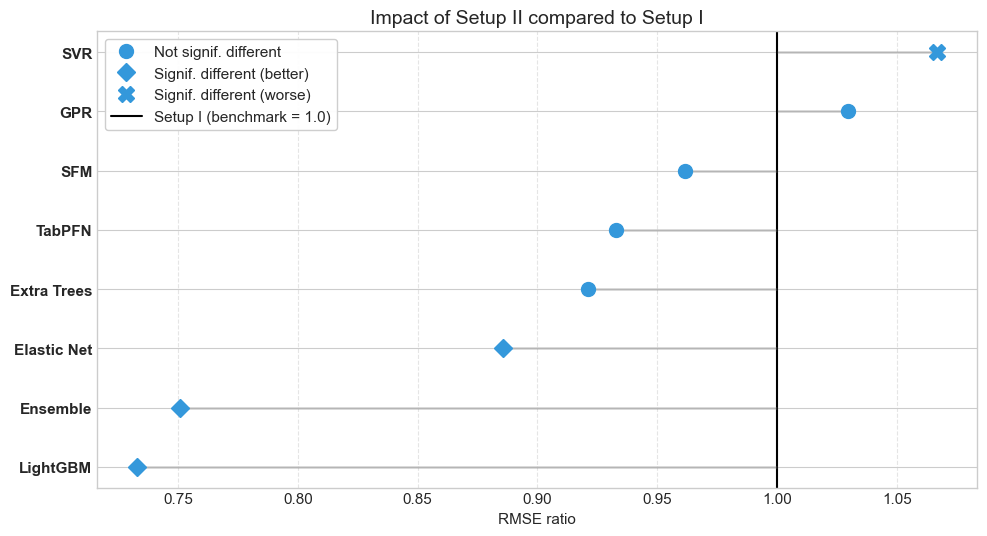


Table for Setup III (RMSE ratio + p-values):
      Model RMSE_Ratio  p_value  Status
        GPR     0.9595 0.004358  better
        SFM     0.9717   0.3184 neutral
Extra Trees     0.9985   0.8814 neutral
Elastic Net     1.0007   0.9909 neutral
        SVR     1.0152   0.4679 neutral
   LightGBM     1.0238   0.5547 neutral
   Ensemble     1.0348   0.4726 neutral
     TabPFN     1.0603  0.06999 neutral
Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Table_Setup_III.csv
Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Pairwise_Setup_III.png


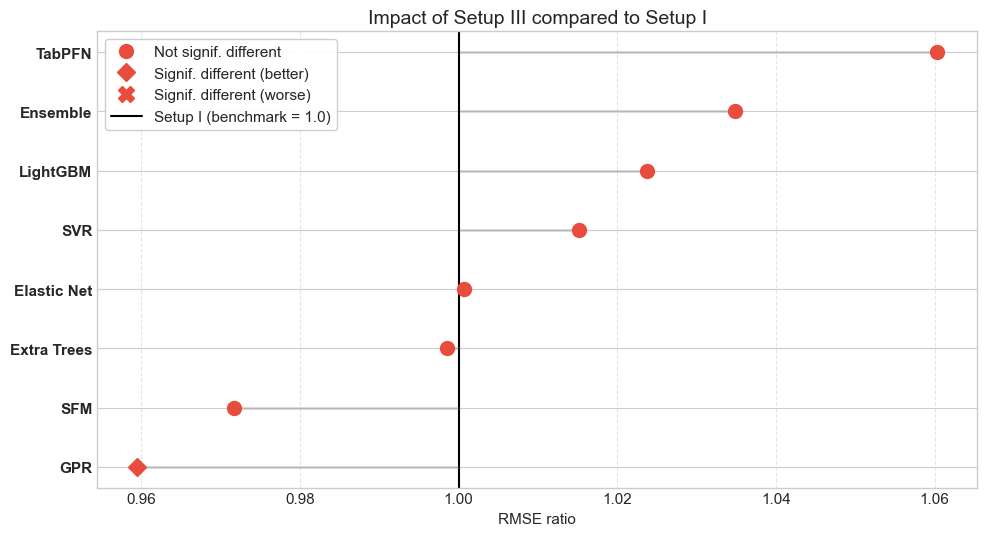

In [8]:
def calculate_dm_test_twosided(series_bench, series_curr, h=1):
    e_bench = series_bench.values
    e_curr = series_curr.values
    d = (e_bench**2) - (e_curr**2)
    T = len(d)
    lags = int(T ** (0.25))
    try:
        res = sm.OLS(d, np.ones(T)).fit(cov_type="HAC", cov_kwds={"maxlags": lags})
        t_stat = res.tvalues[0]
        p_val = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=T - 1))
    except Exception:
        t_stat, p_val = 0.0, 1.0
    return t_stat, p_val


for setup_group in MODEL_MAPPING.values():
    for key, info in setup_group.items():
        base_name = key.split(" (")[0]
        info["label"] = base_name

color_s2 = "#3498db"
color_s3 = "#e74c3c"
setup1_models = MODEL_MAPPING["Setup_1"]
plot_data = []

for k_s1, info_s1 in setup1_models.items():
    if k_s1 not in df_full.columns:
        continue
    model_label = info_s1["label"]

    for setup_key, setup_label_txt, col in [
        ("Setup_2", "Setup II", color_s2),
        ("Setup_3", "Setup III", color_s3),
    ]:
        mod_curr = next(
            (
                k
                for k, v in MODEL_MAPPING[setup_key].items()
                if v.get("label") == model_label and k in df_full.columns
            ),
            None,
        )
        if not mod_curr:
            continue

        tmp = get_common_df(df_full, [k_s1, mod_curr, "y_true"])
        if tmp is None or len(tmp) < 15:
            continue

        val_s1 = rmse_on_df(tmp, k_s1)
        val_curr = rmse_on_df(tmp, mod_curr)
        ratio = val_curr / val_s1

        err_s1 = tmp["y_true"] - tmp[k_s1]
        err_c = tmp["y_true"] - tmp[mod_curr]
        t_stat, p_val = calculate_dm_test_twosided(err_s1, err_c)

        is_sig = p_val < 0.05

        if not is_sig:
            marker = "o"
            msize = 10
            status = "neutral"
        else:
            if ratio < 1.0:
                marker = "D"
                msize = 9
                status = "better"
            else:
                marker = "X"
                msize = 11
                status = "worse"

        plot_data.append(
            {
                "Model": model_label,
                "Setup": setup_label_txt,
                "RMSE_Ratio": ratio,
                "p_value": p_val,
                "Color": col,
                "Marker": marker,
                "MSize": msize,
                "Status": status,
            }
        )

df_plot_all = pd.DataFrame(plot_data)


def create_pairwise_plot(df, setup_filter, color, title_suffix):
    subset = df[df["Setup"] == setup_filter].copy()
    if subset.empty:
        print(f"No data for {setup_filter}")
        return

    subset = subset.sort_values("RMSE_Ratio", ascending=True)
    sorted_models = subset["Model"].tolist()
    y_pos = {mod: i for i, mod in enumerate(sorted_models)}

    table_df = subset[["Model", "RMSE_Ratio", "p_value", "Status"]].copy()
    table_df["RMSE_Ratio"] = table_df["RMSE_Ratio"].map(lambda x: f"{x:.4f}")
    table_df["p_value"] = table_df["p_value"].map(lambda x: f"{x:.4g}")

    print(f"\nTable for {setup_filter} (RMSE ratio + p-values):")
    print(table_df.to_string(index=False))

    safe_setup = setup_filter.replace(" ", "_").replace("/", "-")
    csv_path = FIG_DIR / f"Table_{safe_setup}.csv"
    table_df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")

    fig = plt.figure(figsize=(10, len(sorted_models) * 0.5 + 1.5))

    plt.axvline(1.0, color="black", linewidth=1.5, zorder=1)
    plt.grid(True, axis="x", linestyle="--", alpha=0.5)

    for _, row in subset.iterrows():
        y = y_pos[row["Model"]]
        plt.hlines(
            y,
            min(1.0, row["RMSE_Ratio"]),
            max(1.0, row["RMSE_Ratio"]),
            color="gray",
            alpha=0.3,
            linewidth=2,
            zorder=1,
        )

        plt.plot(
            row["RMSE_Ratio"],
            y,
            marker=row["Marker"],
            markersize=row["MSize"],
            markerfacecolor=row["Color"],
            markeredgecolor=row["Color"],
            linewidth=0,
            zorder=3,
        )

    plt.yticks(range(len(sorted_models)), sorted_models, fontsize=11, fontweight="bold")
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.xlabel("RMSE ratio", fontsize=11)
    plt.title(f"Impact of {title_suffix} compared to Setup I", fontsize=14)

    legend_elements = [
        Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markeredgecolor=color, label="Not signif. different", markersize=10),
        Line2D([0], [0], marker="D", color="w", markerfacecolor=color, markeredgecolor=color, label="Signif. different (better)", markersize=9),
        Line2D([0], [0], marker="X", color="w", markerfacecolor=color, markeredgecolor=color, label="Signif. different (worse)", markersize=11),
        Line2D([0], [0], color="black", linewidth=1.5, label="Setup I (benchmark = 1.0)"),
    ]

    plt.legend(handles=legend_elements, loc="upper left", ncol=1, frameon=True, framealpha=0.95)
    plt.tight_layout()

    img_path = FIG_DIR / f"Pairwise_{safe_setup}.png"
    fig.savefig(img_path, dpi=300, bbox_inches="tight")
    print(f"Saved: {img_path}")

    plt.show()


if not df_plot_all.empty:
    create_pairwise_plot(df_plot_all, "Setup II", color_s2, "Setup II")
    create_pairwise_plot(df_plot_all, "Setup III", color_s3, "Setup III")
else:
    print("No plot data available.")

# Figure R1 (dot plot vs running mean baseline)
Setup I vs Setup II relative RMSE vs a chosen baseline + table.

Baselines found in df_full: ['AR(1)', 'RW', 'Grand Mean', 'Running Mean']

[Figure R1] Start baseline = AR(1)
[Figure R1] Collected points: 16
>>> TABLE: Performance vs. AR(1) <<<
[Figure R1] Saved table: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Table_R1_vs_AR(1).csv


,Setup,Model,Rel_RMSE,p_val
3,Setup I,TabPFN,0.8939,0.3305
7,Setup I,Ensemble,0.9096,0.3717
6,Setup I,SVR,0.9384,0.3537
0,Setup I,Extra Trees,0.9393,0.3946
2,Setup I,Elastic Net,0.9406,0.5684
1,Setup I,LightGBM,0.9418,0.4703
4,Setup I,SFM,0.9799,0.8296
5,Setup I,GPR,0.9965,0.9347
15,Setup II,Ensemble,0.6828,0.0558
9,Setup II,LightGBM,0.6903,0.0470


[Figure R1] Saved figure: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Figure_R1_vs_AR(1).png


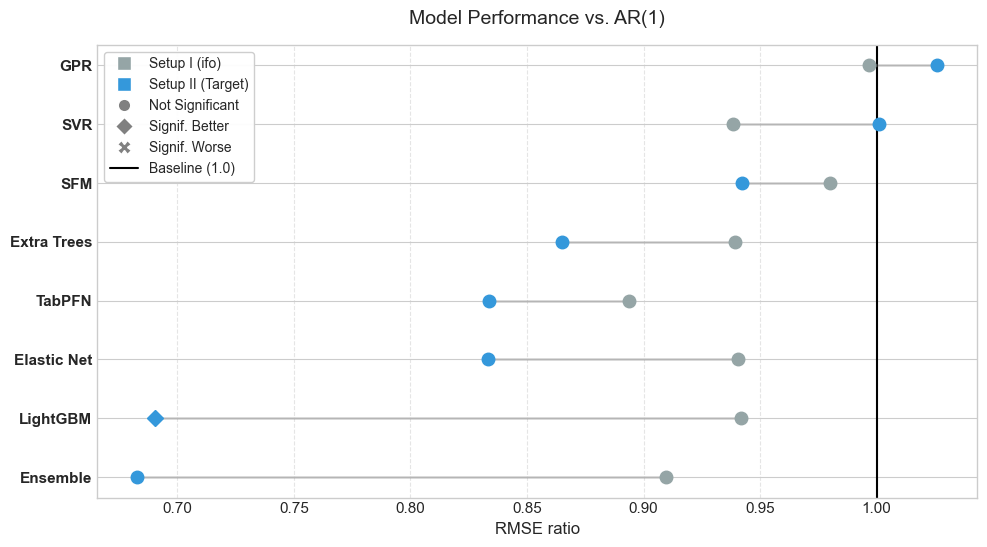


[Figure R1] Start baseline = RW
[Figure R1] Collected points: 16
>>> TABLE: Performance vs. RW <<<
[Figure R1] Saved table: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Table_R1_vs_RW.csv


,Setup,Model,Rel_RMSE,p_val
3,Setup I,TabPFN,0.9325,0.3379
7,Setup I,Ensemble,0.9489,0.4206
6,Setup I,SVR,0.9790,0.4234
0,Setup I,Extra Trees,0.9799,0.5655
2,Setup I,Elastic Net,0.9813,0.7958
1,Setup I,LightGBM,0.9826,0.6636
4,Setup I,SFM,1.0223,0.7303
5,Setup I,GPR,1.0397,0.0001
15,Setup II,Ensemble,0.7124,0.0203
9,Setup II,LightGBM,0.7202,0.0138


[Figure R1] Saved figure: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Figure_R1_vs_RW.png


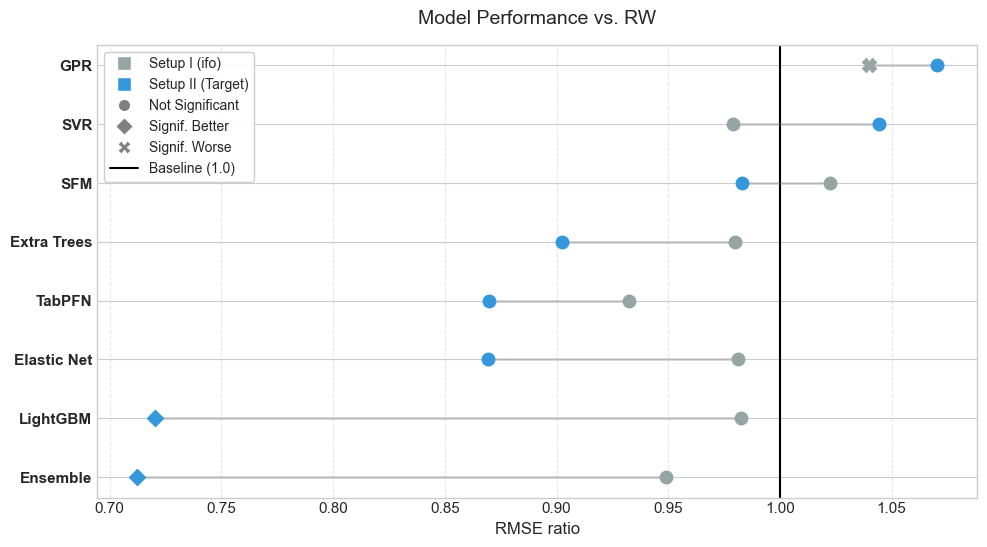


[Figure R1] Start baseline = Grand Mean
[Figure R1] Collected points: 16
>>> TABLE: Performance vs. Grand Mean <<<
[Figure R1] Saved table: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Table_R1_vs_Grand_Mean.csv


,Setup,Model,Rel_RMSE,p_val
3,Setup I,TabPFN,0.9305,0.3324
7,Setup I,Ensemble,0.9468,0.4107
6,Setup I,SVR,0.9769,0.4038
0,Setup I,Extra Trees,0.9778,0.5397
2,Setup I,Elastic Net,0.9791,0.7760
1,Setup I,LightGBM,0.9804,0.6365
4,Setup I,SFM,1.0201,0.7603
5,Setup I,GPR,1.0374,0.0001
15,Setup II,Ensemble,0.7108,0.0209
9,Setup II,LightGBM,0.7186,0.0144


[Figure R1] Saved figure: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Figure_R1_vs_Grand_Mean.png


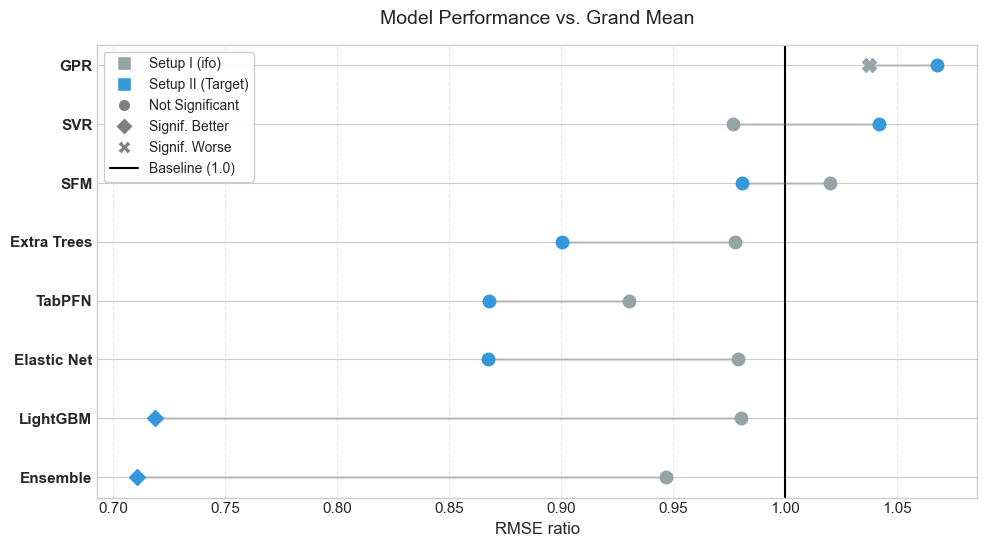


[Figure R1] Start baseline = Running Mean
[Figure R1] Collected points: 16
>>> TABLE: Performance vs. Running Mean <<<
[Figure R1] Saved table: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Table_R1_vs_Running_Mean.csv


,Setup,Model,Rel_RMSE,p_val
3,Setup I,TabPFN,0.9245,0.2960
7,Setup I,Ensemble,0.9407,0.3635
6,Setup I,SVR,0.9706,0.2969
0,Setup I,Extra Trees,0.9714,0.4236
2,Setup I,Elastic Net,0.9728,0.7086
1,Setup I,LightGBM,0.9741,0.5438
4,Setup I,SFM,1.0135,0.8345
5,Setup I,GPR,1.0307,0.0028
15,Setup II,Ensemble,0.7062,0.0203
9,Setup II,LightGBM,0.7140,0.0141


[Figure R1] Saved figure: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Figure_R1_vs_Running_Mean.png


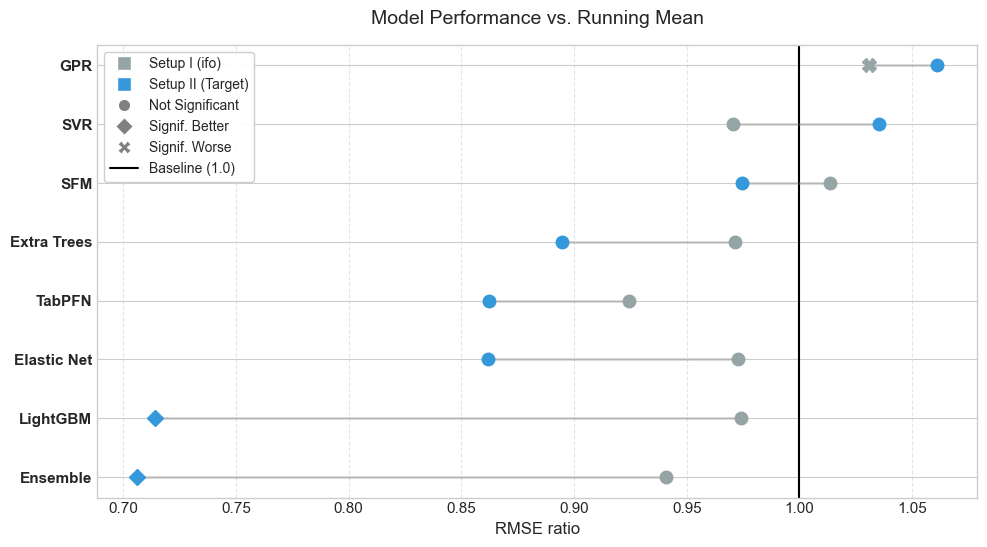

In [16]:
# ============================================================
# FIXED: DM-Test + RelRMSE-vs-Baseline + Figure R1 + Runner
# (und ein Patch für deinen Pairwise-Chunk)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import statsmodels.api as sm
import scipy.stats as stats
from pathlib import Path
from IPython.display import display


# -------------------------
# 1) DM test (two-sided)
# -------------------------
def calculate_dm_test_twosided(series_bench, series_curr, h=None):
    """
    DM-Test (two-sided) auf d_t = e_bench^2 - e_curr^2.
    HAC-robust mit maxlags = floor(T^0.25) falls h=None.
    """
    e_bench = np.asarray(series_bench.values, dtype=float)
    e_curr = np.asarray(series_curr.values, dtype=float)
    d = (e_bench**2) - (e_curr**2)

    T = len(d)
    if T < 5:
        return 0.0, 1.0

    maxlags = int(T ** 0.25) if h is None else int(h)
    try:
        res = sm.OLS(d, np.ones(T)).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
        t_stat = float(res.tvalues[0])
        p_val = float(2 * (1 - stats.t.cdf(np.abs(t_stat), df=T - 1)))
    except Exception:
        t_stat, p_val = 0.0, 1.0

    return t_stat, p_val


# Alias, falls irgendwo im Notebook noch der alte Name verwendet wird
calculate_dm_test_twosided_local = calculate_dm_test_twosided


# -------------------------
# 2) Helper: common sample
# -------------------------
def get_common_df(df, cols):
    out = df[cols].dropna()
    return out if not out.empty else None


def rmse_on_df(df, pred_col):
    err = df["y_true"] - df[pred_col]
    return float(np.sqrt((err**2).mean()))


# -------------------------
# 3) RelRMSE vs Baseline (same sample) + DM
# -------------------------
def rel_rmse_vs_baseline_same_sample(df: pd.DataFrame, model_col: str, baseline_col: str, min_n: int = 15):
    """
    Returns:
      rel (float) = RMSE(model) / RMSE(baseline) auf identischem dropna-Sample
      is_sig (bool) p<0.05
      is_better (bool) signifikant besser (t_stat > 0)
      is_worse (bool) signifikant schlechter (t_stat < 0)
      p_val (float)
    """
    tmp = get_common_df(df, ["y_true", model_col, baseline_col])
    if tmp is None or len(tmp) < min_n:
        return np.nan, False, False, False, np.nan

    rmse_model = rmse_on_df(tmp, model_col)
    rmse_base = rmse_on_df(tmp, baseline_col)
    if rmse_base <= 0 or not np.isfinite(rmse_base):
        return np.nan, False, False, False, np.nan

    rel = rmse_model / rmse_base

    e_bl = tmp["y_true"] - tmp[baseline_col]
    e_mod = tmp["y_true"] - tmp[model_col]
    t_stat, p_val = calculate_dm_test_twosided(e_bl, e_mod)

    is_sig = (p_val < 0.05)
    is_better = is_sig and (t_stat > 0)
    is_worse = is_sig and (t_stat < 0)

    return float(rel), bool(is_sig), bool(is_better), bool(is_worse), float(p_val)


# -------------------------
# 4) Figure R1 (Setup I vs II) vs Baseline
# -------------------------
def run_figure_r1_for_baseline(df_full: pd.DataFrame, ref_bl: str, fig_dir: Path, min_n: int = 15):
    print(f"\n[Figure R1] Start baseline = {ref_bl}")

    if "y_true" not in df_full.columns:
        print("[Figure R1] ERROR: df_full hat keine 'y_true' Spalte.")
        return
    if ref_bl not in df_full.columns:
        print(f"[Figure R1] SKIP: Baseline '{ref_bl}' nicht in df_full.columns.")
        return

    fig_dir = Path(fig_dir)
    fig_dir.mkdir(parents=True, exist_ok=True)

    data_rows = []
    setup_defs = [("Setup_1", "Setup I"), ("Setup_2", "Setup II")]

    for setup_key, setup_label in setup_defs:
        if setup_key not in MODEL_MAPPING:
            continue

        for model_key, info in MODEL_MAPPING[setup_key].items():
            if model_key not in df_full.columns:
                continue

            clean_name = info.get("label", model_key.split(" (")[0])

            rel, is_sig, is_better, is_worse, p_val = rel_rmse_vs_baseline_same_sample(
                df_full, model_key, ref_bl, min_n=min_n
            )
            if not np.isfinite(rel):
                continue

            if not is_sig:
                marker = "o"
            elif is_better:
                marker = "D"
            else:
                marker = "X"

            data_rows.append(
                {
                    "Model": clean_name,
                    "Setup": setup_label,
                    "Rel_RMSE": rel,
                    "Marker": marker,
                    "IsSig": is_sig,
                    "p_val": p_val,
                }
            )

    df_plot = pd.DataFrame(data_rows)
    print(f"[Figure R1] Collected points: {len(df_plot)}")
    if df_plot.empty:
        print(f"[{ref_bl}] Keine Daten für Tabelle/Plot.")
        return

    # ---- Tabelle + CSV ----
    print(f">>> TABLE: Performance vs. {ref_bl} <<<")
    table_df = df_plot[["Setup", "Model", "Rel_RMSE", "p_val"]].copy()
    table_df = table_df.sort_values(["Setup", "Rel_RMSE"])

    safe_bl = str(ref_bl).replace(" ", "_").replace("/", "-")
    csv_path = fig_dir / f"Table_R1_vs_{safe_bl}.csv"
    table_df.to_csv(csv_path, index=False)
    print(f"[Figure R1] Saved table: {csv_path}")

    try:
        display(
            table_df.style.format({"Rel_RMSE": "{:.4f}", "p_val": "{:.4f}"})
            .background_gradient(subset=["Rel_RMSE"], cmap="RdYlGn_r", vmin=0.8, vmax=1.2)
        )
    except Exception:
        print(table_df.to_string(index=False))

    # ---- Sortierung (nach Setup II wenn vorhanden) ----
    s2_subset = df_plot[df_plot["Setup"] == "Setup II"].copy()
    if s2_subset.empty:
        sort_order = df_plot.sort_values("Rel_RMSE")["Model"].unique()
    else:
        sort_order = s2_subset.sort_values("Rel_RMSE")["Model"].unique()

    sort_order = list(sort_order)
    model_map_y = {m: i for i, m in enumerate(sort_order)}

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(10, len(sort_order) * 0.45 + 2.0), dpi=100)
    ax.axvline(1.0, color="black", linewidth=1.5, zorder=1)
    ax.grid(True, axis="x", linestyle="--", alpha=0.5)

    # connector lines per model
    for m in sort_order:
        sub = df_plot[df_plot["Model"] == m]
        if sub.empty:
            continue
        y = model_map_y[m]
        ax.hlines(
            y,
            sub["Rel_RMSE"].min(),
            sub["Rel_RMSE"].max(),
            color="gray",
            alpha=0.3,
            linewidth=2,
            zorder=2,
        )

    colors = {"Setup I": "#95a5a6", "Setup II": "#3498db"}

    for setup in ["Setup I", "Setup II"]:
        sub = df_plot[df_plot["Setup"] == setup]
        for _, row in sub.iterrows():
            y = model_map_y.get(row["Model"])
            if y is None:
                continue
            msize = 8 if row["IsSig"] else 9
            if row["Marker"] == "X":
                msize = 10

            ax.plot(
                row["Rel_RMSE"], y,
                marker=row["Marker"],
                markersize=msize,
                markerfacecolor=colors.get(setup, "gray"),
                markeredgecolor=colors.get(setup, "gray"),
                linestyle="",
                zorder=3,
            )

    ax.set_yticks(np.arange(len(sort_order)))
    ax.set_yticklabels(sort_order, fontsize=11, fontweight="bold")
    ax.set_xlabel("RMSE ratio", fontsize=12)
    ax.set_title(f"Model Performance vs. {ref_bl}", fontsize=14, pad=15)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    legend_elements = [
        Line2D([0], [0], marker="s", color="w", markerfacecolor=colors["Setup I"], label="Setup I (ifo)", markersize=10),
        Line2D([0], [0], marker="s", color="w", markerfacecolor=colors["Setup II"], label="Setup II (Target)", markersize=10),
        Line2D([0], [0], marker="o", color="w", markerfacecolor="gray", label="Not Significant", markersize=9),
        Line2D([0], [0], marker="D", color="w", markerfacecolor="gray", label="Signif. Better", markersize=9),
        Line2D([0], [0], marker="X", color="w", markerfacecolor="gray", label="Signif. Worse", markersize=10),
        Line2D([0], [0], color="black", linewidth=1.5, label="Baseline (1.0)"),
    ]
    ax.legend(handles=legend_elements, loc="upper left", frameon=True, framealpha=0.95, fontsize=10)

    fig.tight_layout()
    img_path = fig_dir / f"Figure_R1_vs_{safe_bl}.png"
    fig.savefig(img_path, dpi=300, bbox_inches="tight")
    print(f"[Figure R1] Saved figure: {img_path}")

    plt.show()


# -------------------------
# 5) RUNNER: alle Baselines
# -------------------------
baseline_order = [b for b in MODEL_MAPPING["Baselines"].keys() if b in df_full.columns]
print("Baselines found in df_full:", baseline_order)

for bl in baseline_order:
    run_figure_r1_for_baseline(df_full, bl, FIG_DIR)


# ============================================================
# PATCH für deinen Pairwise-Chunk (falls du da noch _local nutzt):
# Ersetze dort die Zeile mit calculate_dm_test_twosided_local(...)
# durch:
#
# t_stat, p_val = calculate_dm_test_twosided(err_s1, err_c)
#
# und NICHT mit e_bl/e_mod.
# ============================================================



# Cumulative squared error (Setup I & II)
Absolute cumulative squared error curves.

Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/CSE_Setup_I.png


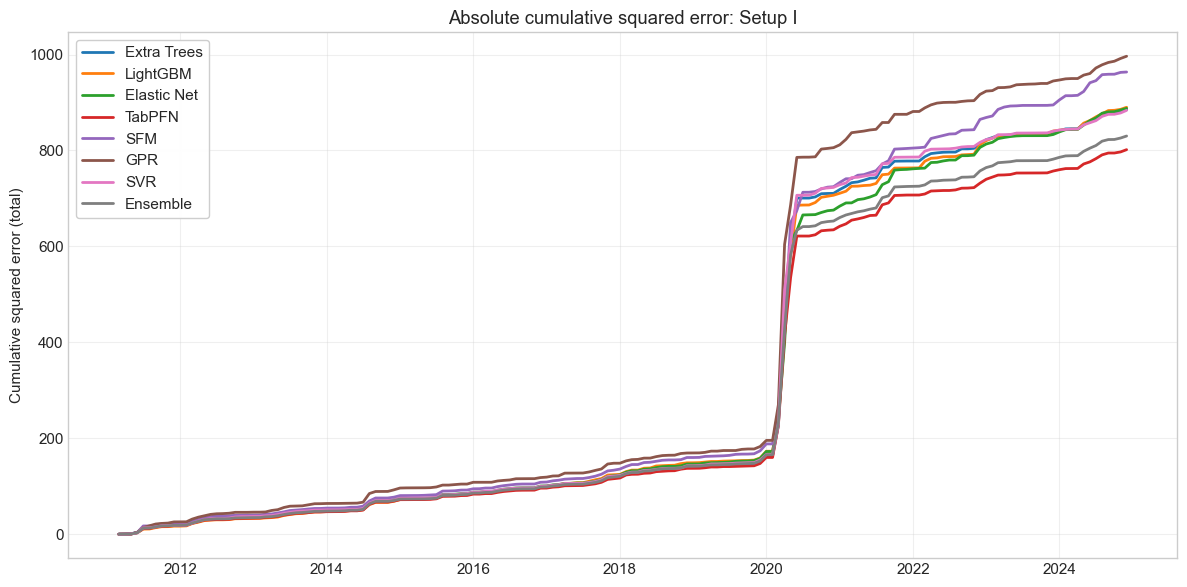

Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/CSE_Setup_II.png


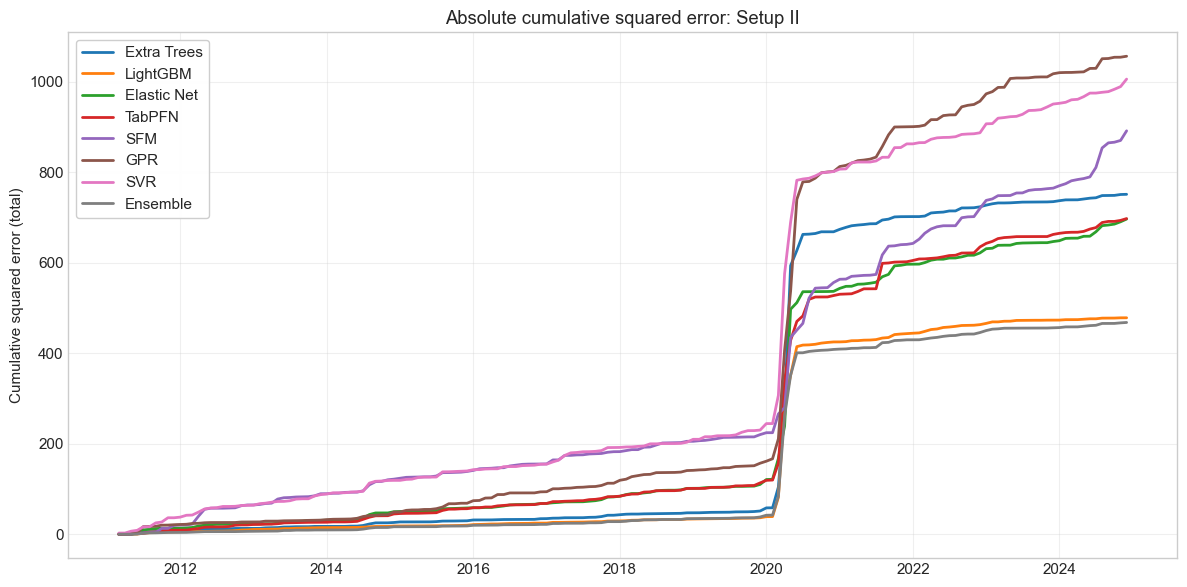

In [11]:
s1_keys = [c for c in df_full.columns if c in MODEL_MAPPING["Setup_1"] and c != "y_true"]
s2_keys = [c for c in df_full.columns if c in MODEL_MAPPING["Setup_2"] and c != "y_true"]

if s1_keys:
    plt.figure(figsize=(12, 6))
    for k in s1_keys:
        temp = df_full[[k, "y_true"]].dropna()
        if temp.empty:
            continue

        cse_mod = ((temp["y_true"] - temp[k]) ** 2).cumsum()
        clean_label = k.split(" (")[0]
        plt.plot(cse_mod.index, cse_mod, label=clean_label, linewidth=2)

    plt.title("Absolute cumulative squared error: Setup I")
    plt.ylabel("Cumulative squared error (total)")
    plt.legend(loc="upper left", frameon=True, framealpha=0.95)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    save_path = FIG_DIR / "CSE_Setup_I.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved: {save_path}")

    plt.show()
else:
    print("No models found for Setup I.")

if s2_keys:
    plt.figure(figsize=(12, 6))
    for k in s2_keys:
        temp = df_full[[k, "y_true"]].dropna()
        if temp.empty:
            continue

        cse_mod = ((temp["y_true"] - temp[k]) ** 2).cumsum()
        clean_label = k.split(" (")[0]
        plt.plot(cse_mod.index, cse_mod, label=clean_label, linewidth=2)

    plt.title("Absolute cumulative squared error: Setup II")
    plt.ylabel("Cumulative squared error (total)")
    plt.legend(loc="upper left", frameon=True, framealpha=0.95)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    save_path = FIG_DIR / "CSE_Setup_II.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved: {save_path}")

    plt.show()
else:
    print("No models found for Setup II.")

# Feature importance (rank stability, turnover, concentration)
Loads importance panel and generates three figures.

# Consensus Top-20 share per model
Share of total importance explained by consensus Top-20 (EN/ET/LGBM).

Consensus Top-20 selected (rank 1: Herstellung_von_sonstigen_chemischen_Erzeugnissen.Auftragsbestand_gegen_Vormonat__lag2)

=== Share of model importance explained by consensus Top-20 ===
       Share_of_Consensus_Top20 (%)
Model                              
EN                             1.15
ET                             3.38
LGBM                          19.15
Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Consensus_Top20_Share_By_Model.png


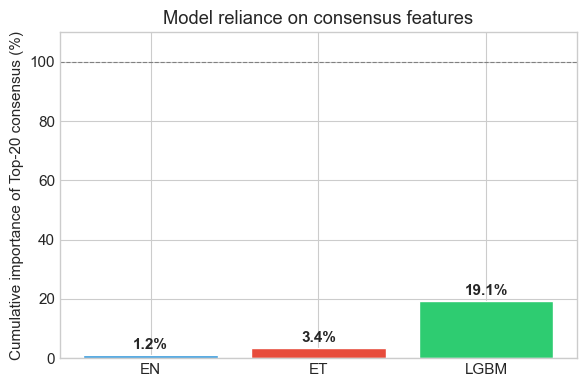

In [12]:
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "feature_importance" / "outputs_no_missing"
run_name = "full_run"

path_mean = OUTPUT_DIR / f"raw_importance_MEAN_{run_name}.csv"
if not path_mean.exists():
    raise FileNotFoundError("Run the mean-importance job first!")

df_mean = pd.read_csv(path_mean, index_col=0)
df_mean_norm = df_mean.div(df_mean.sum(axis=1), axis=0)

top_20_consensus = df_mean_norm.mean().sort_values(ascending=False).head(20).index.tolist()
print(f"Consensus Top-20 selected (rank 1: {top_20_consensus[0]})")

models = ["EN", "ET", "LGBM"]
results = []

for m in models:
    path_model = OUTPUT_DIR / f"raw_importance_{m}_{run_name}.csv"

    if path_model.exists():
        df_m = pd.read_csv(path_model, index_col=0)
        df_m_norm = df_m.div(df_m.sum(axis=1), axis=0).fillna(0.0)
        df_top20_only = df_m_norm.reindex(columns=top_20_consensus, fill_value=0.0)
        avg_share = df_top20_only.sum(axis=1).mean() * 100

        results.append({"Model": m, "Share_of_Consensus_Top20 (%)": avg_share})
    else:
        print(f"Warning: file for {m} not found.")

df_res = pd.DataFrame(results).set_index("Model")
print("\n=== Share of model importance explained by consensus Top-20 ===")
print(df_res.round(2))

plt.figure(figsize=(6, 4))
bars = plt.bar(df_res.index, df_res["Share_of_Consensus_Top20 (%)"], color=["#3498db", "#e74c3c", "#2ecc71"])
plt.axhline(100, color="gray", linestyle="--", linewidth=0.8)
plt.ylabel("Cumulative importance of Top-20 consensus (%)")
plt.title("Model reliance on consensus features")
plt.ylim(0, 110)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 1, f"{height:.1f}%", ha="center", va="bottom", fontweight="bold")

plt.tight_layout()

save_path = FIG_DIR / "Consensus_Top20_Share_By_Model.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Saved: {save_path}")

plt.show()

# Feature concentration table
How many features needed for 50/95/99% cumulative importance (per model).

In [13]:
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "feature_importance" / "outputs_no_missing"
run_name = "full_run"
models = ["EN", "ET", "LGBM", "MEAN"]
thresholds = [0.50, 0.95, 0.99]

results_concentration = []

print(f"Analyzing feature concentration for: {models}\n")

for m in models:
    path_model = OUTPUT_DIR / f"raw_importance_{m}_{run_name}.csv"

    if path_model.exists():
        df = pd.read_csv(path_model, index_col=0)
        df = df.abs()
        df_norm = df.div(df.sum(axis=1), axis=0).fillna(0.0)

        mean_importance = df_norm.mean().sort_values(ascending=False)
        cum_curve = mean_importance.cumsum()
        total_feats = len(cum_curve)

        row = {"Model": m, "Total Features": total_feats}

        for t in thresholds:
            if cum_curve.max() < t:
                n_needed = total_feats
            else:
                n_needed = np.argmax(cum_curve.values >= t) + 1

            pct_needed = (n_needed / total_feats) * 100
            row[f"{int(t*100)}% Expl."] = f"{n_needed} ({pct_needed:.2f}%)"  # <- 2 decimals

        results_concentration.append(row)
    else:
        print(f"Warning: file for {m} not found.")

df_conc = pd.DataFrame(results_concentration).set_index("Model")

print("=== FEATURE CONCENTRATION ANALYSIS ===")
print("How many features are needed to explain X% of total importance?")
print("-" * 80)
print(df_conc.to_string())
print("-" * 80)


Analyzing feature concentration for: ['EN', 'ET', 'LGBM', 'MEAN']

=== FEATURE CONCENTRATION ANALYSIS ===
How many features are needed to explain X% of total importance?
--------------------------------------------------------------------------------
       Total Features      50% Expl.      95% Expl.      99% Expl.
Model                                                             
EN               4320  1049 (24.28%)  3576 (82.78%)  4100 (94.91%)
ET               4320   706 (16.34%)  3499 (81.00%)  4082 (94.49%)
LGBM             4320    118 (2.73%)  1305 (30.21%)  2268 (52.50%)
MEAN             4320   643 (14.88%)  3473 (80.39%)  4079 (94.42%)
--------------------------------------------------------------------------------


# DM test (single example)
GPR (Setup III) vs RW

In [14]:
model_col = "GPR (S3)"
bench_col = "RW"
target_col = "y_true"

df_test = df_full[[model_col, bench_col, target_col]].dropna()

if len(df_test) > 15:
    e_bench = df_test[target_col] - df_test[bench_col]
    e_model = df_test[target_col] - df_test[model_col]
    d = (e_bench**2) - (e_model**2)

    T = len(d)
    lags = int(T ** (0.25))
    res = sm.OLS(d, np.ones(T)).fit(cov_type="HAC", cov_kwds={"maxlags": lags})

    t_stat = res.tvalues[0]
    p_val_two_sided = res.pvalues[0]

    rmse_model = np.sqrt(np.mean(e_model**2))
    rmse_bench = np.sqrt(np.mean(e_bench**2))
    ratio = rmse_model / rmse_bench

    is_sig_5 = p_val_two_sided < 0.05
    is_better = (t_stat > 0) and is_sig_5

    print(f"--- DM test: {model_col} vs {bench_col} ---")
    print(f"n           : {T}")
    print(f"RMSE model  : {rmse_model:.4f}")
    print(f"RMSE bench  : {rmse_bench:.4f}")
    print(f"Ratio       : {ratio:.4f}")
    print(f"t-statistic : {t_stat:.4f}")
    print(f"p-value (2s): {p_val_two_sided:.4f}")

    if is_better:
        print("Result: model is significantly better (p < 0.05).")
    elif is_sig_5 and t_stat < 0:
        print("Result: model is significantly worse (p < 0.05).")
    else:
        print("Result: no significant difference.")
else:
    print("Not enough data for the test.")

--- DM test: GPR (S3) vs RW ---
n           : 166
RMSE model  : 2.3508
RMSE bench  : 2.3566
Ratio       : 0.9975
t-statistic : 0.2588
p-value (2s): 0.7958
Result: no significant difference.


# Elastic Net screening
EN 7000 vs 700 on the common active sample (one-sided DM: is 7000 better?).

In [19]:
EN_700_RUN = "elastic_net_with_target_700"
EN_7000_RUN = "elastic_net_with_targetfeatures_7000"


def _load_active_preds_by_runid(run_id: str) -> pd.DataFrame:
    path = STAGEB_DIR / run_id / "monthly" / "preds.csv"
    if not path.exists():
        raise FileNotFoundError(f"Missing: {path}")
    df = pd.read_csv(path, parse_dates=["date_t_plus_1"])
    df = df[df["is_active"] == True].copy()
    df = df.set_index("date_t_plus_1").sort_index()
    df = df.reset_index().groupby("date_t_plus_1").first().sort_index()
    return df[["y_true", "y_pred"]]


df700 = _load_active_preds_by_runid(EN_700_RUN)
df7000 = _load_active_preds_by_runid(EN_7000_RUN)

tmp = pd.concat(
    [
        df700.rename(columns={"y_pred": "pred_700"})[["y_true", "pred_700"]],
        df7000.rename(columns={"y_pred": "pred_7000"})[["pred_7000"]],
    ],
    axis=1,
).dropna()

e700 = tmp["y_true"] - tmp["pred_700"]
e7000 = tmp["y_true"] - tmp["pred_7000"]

t_stat, p_val = calculate_dm_test_onesided(e_ref=e700, e_comp=e7000, h=12)

rmse_700 = float(np.sqrt(np.mean(e700**2)))
rmse_7000 = float(np.sqrt(np.mean(e7000**2)))
ratio = rmse_7000 / rmse_700

print("EN: 7000 vs 700 (active StageB, common sample)")
print(f"N_common   : {len(tmp)}")
print(f"RMSE_700   : {rmse_700:.4f}")
print(f"RMSE_7000  : {rmse_7000:.4f}")
print(f"Ratio      : {ratio:.4f}  (<1 means 7000 better)")
print(f"DM z/t-stat: {t_stat:.3f}")
print(f"DM p-value : {p_val:.4f}  (one-sided: 7000 better)")

EN: 7000 vs 700 (active StageB, common sample)
N_common   : 166
RMSE_700   : 2.0482
RMSE_7000  : 2.0449
Ratio      : 0.9984  (<1 means 7000 better)
DM z/t-stat: 0.149
DM p-value : 0.4409  (one-sided: 7000 better)


## Rank Stability Anaysis

Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Feature_Rank_Stability_Top20.png


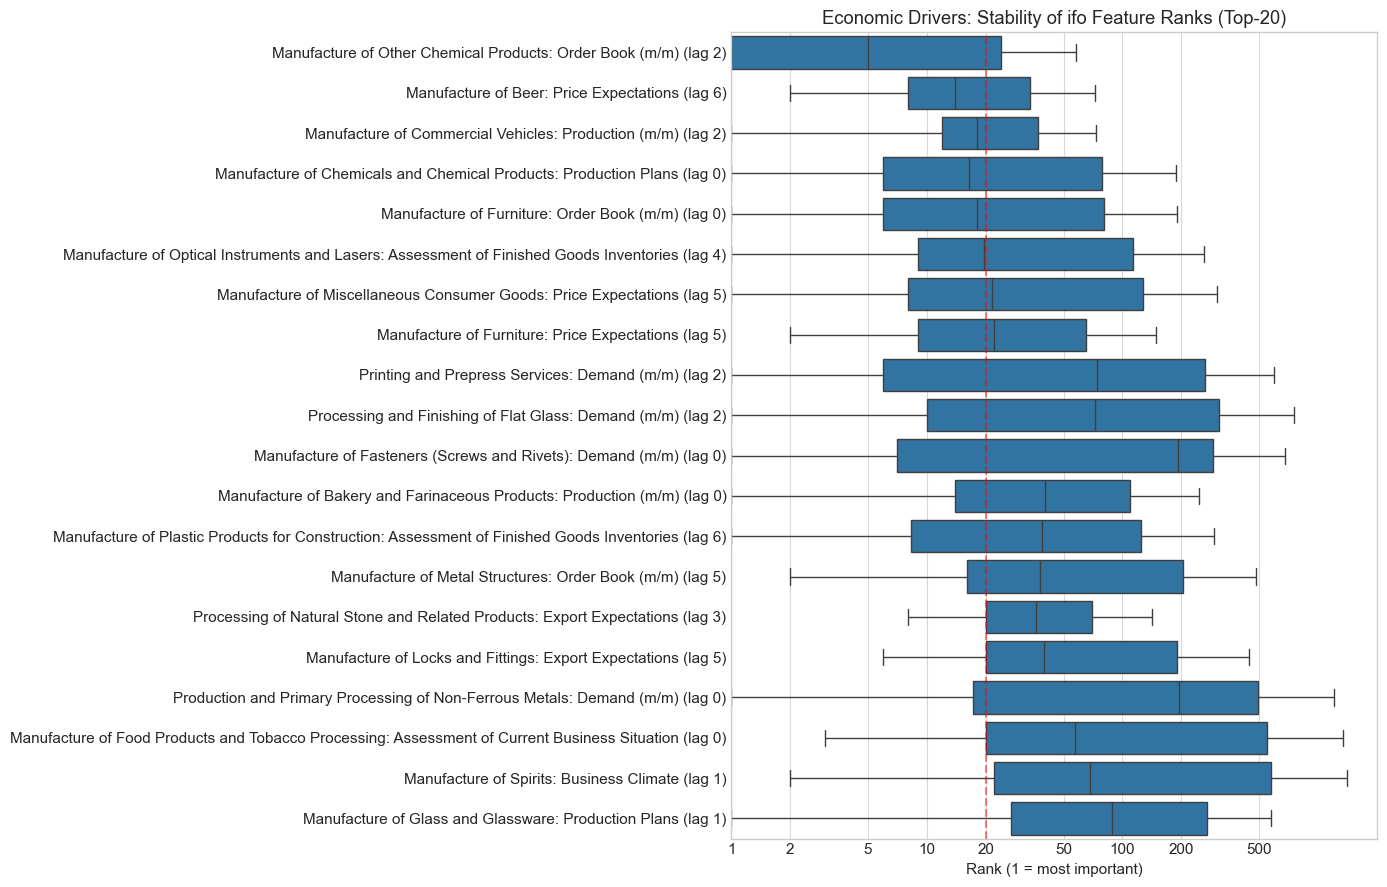

Saved: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/tests/figures/Feature_Jaccard_Stability.png


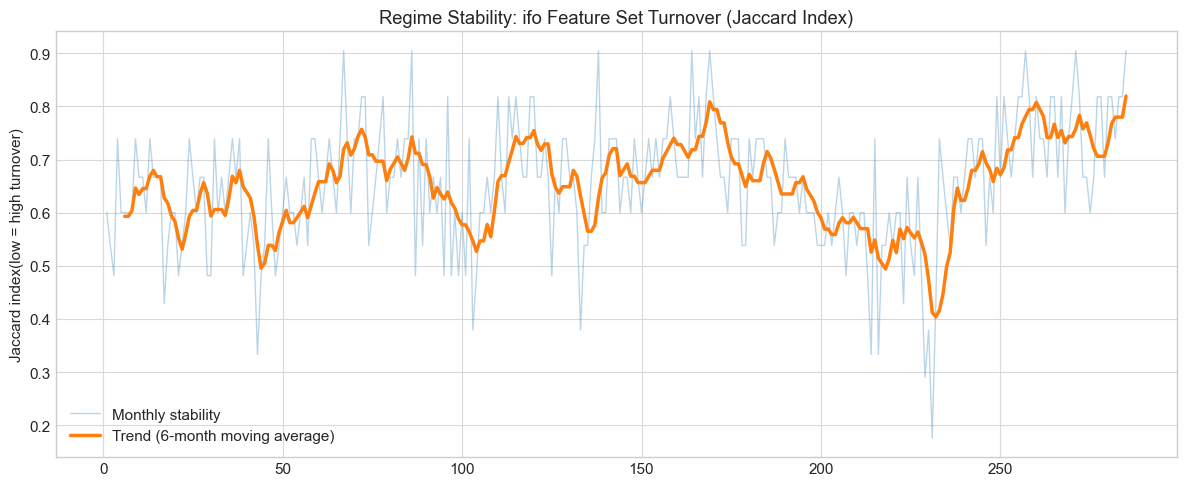

In [17]:
# =============================================================================
# Feature importance plots: Rank stability (boxplot) + Jaccard turnover
# (WITH label mappings DE -> EN for copy/paste)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Label mappings (DE -> EN)
# -------------------------
SECTOR_MAP = {
    # Chemie & Pharma
    "Herstellung_von_sonstigen_chemischen_Erzeugnissen": "Manufacture of Other Chemical Products",
    "Herstellung_von_chemischen_Erzeugnissen": "Manufacture of Chemicals and Chemical Products",
    "Herstellung_von_Baubedarfsartikeln_aus_Kunststoffen": "Manufacture of Plastic Products for Construction",

    # Lebensmittel & Genuss
    "Herstellung_von_Bier": "Manufacture of Beer",
    "Herstellung_von_Back__und_Teigwaren": "Manufacture of Bakery and Farinaceous Products",
    "Ern_hrungsgewerbe_und_Tabakverarbeitung": "Manufacture of Food Products and Tobacco Processing",
    "Herstellung_von_Spirituosen": "Manufacture of Spirits",

    # Fahrzeuge
    "Herstellung_von_Nutzkraftwagen": "Manufacture of Commercial Vehicles",
    "Herstellung_von_Kraftwagen_und_Kraftwagenteilen": "Manufacture of Motor Vehicles and Parts",

    # Metall & Maschinen
    "Herstellung_von_Schrauben_und_Nieten": "Manufacture of Fasteners (Screws and Rivets)",
    "Herstellung_von_Metallkonstruktionen": "Manufacture of Metal Structures",
    "Herstellung_von_Schl_ssern_und_Beschl_gen": "Manufacture of Locks and Fittings",
    "Erzeugung_und_erste_Bearbeitung_von_NE_Metallen": "Production and Primary Processing of Non-Ferrous Metals",
    "Maschinenbau": "Manufacture of Machinery and Equipment",

    # Glas, Keramik, Steine
    "Veredelung_und_Bearbeitung_von_Flachglas": "Processing and Finishing of Flat Glass",
    "Be__und_Verarbeitung_von_Naturwerk__und_Natursteinen": "Processing of Natural Stone and Related Products",
    "Herstellung_von_Glas_und_Glaswaren": "Manufacture of Glass and Glassware",

    # Sonstige
    "Herstellung_von_M_beln": "Manufacture of Furniture",
    "Herstellung_von_optischen_Instrumenten_und_Lasern": "Manufacture of Optical Instruments and Lasers",
    "Herstellung_von_Gebrauchsg_tern": "Manufacture of Miscellaneous Consumer Goods",
    "Druck_und_Medienvorstufe": "Printing and Prepress Services",
}

INDICATOR_MAP = {
    "Auftragsbestand_gegen_Vormonat": "Order Book (m/m)",
    "Preiserwartungen": "Price Expectations",
    "Produktion_gegen_Vormonat": "Production (m/m)",
    "Produktionspl_ne": "Production Plans",
    "Fertigwarenlager_Beurteilung": "Assessment of Finished Goods Inventories",
    "Nachfrage_gegen_Vormonat": "Demand (m/m)",
    "Gesch_ftslage_Beurteilung": "Assessment of Current Business Situation",
    "Gesch_ftsklima": "Business Climate",
    "Exporterwartungen": "Export Expectations",
    "Besch_ftigungserwartungen": "Employment Expectations",
}
def translate_feature_label(raw_label: str) -> str:
    """
    Expected: <sector>.<indicator>__lagX
    Returns:  "Sector EN: Indicator EN (lag X)"
    Fallback: original parts if not found in mapping.
    """
    if not isinstance(raw_label, str):
        return str(raw_label)

    # lag
    lag_str = ""
    base = raw_label
    if "__lag" in raw_label:
        base, lag_part = raw_label.split("__lag", 1)
        lag_str = f" (lag {lag_part})"

    # sector / indicator
    if "." in base:
        sector_raw, indicator_raw = base.split(".", 1)
    else:
        sector_raw, indicator_raw = base, ""

    sec_en = SECTOR_MAP.get(sector_raw, sector_raw)
    ind_en = INDICATOR_MAP.get(indicator_raw, indicator_raw)

    if ind_en:
        return f"{sec_en}: {ind_en}{lag_str}"
    return f"{sec_en}{lag_str}"


# -------------------------
# Load MEAN importance panel
# -------------------------
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "feature_importance" / "outputs_no_missing"
run_name = "full_run"

path_imp = OUTPUT_DIR / f"raw_importance_MEAN_{run_name}.csv"
if not path_imp.exists():
    raise FileNotFoundError(f"Missing: {path_imp}")

df_imp = pd.read_csv(path_imp, index_col=0)

# Normalize row-wise (and abs for safety)
df_imp = df_imp.abs()
df_imp = df_imp.div(df_imp.sum(axis=1), axis=0).fillna(0.0)

# -------------------------
# PLOT 1: Rank stability (Top-20) boxplot (translated labels)
# -------------------------
df_ranks = df_imp.rank(axis=1, ascending=False, method="min")
is_top20 = (df_ranks <= 20)

top_20_feats = is_top20.mean().sort_values(ascending=False).head(20).index.tolist()
df_box = df_ranks[top_20_feats].melt(var_name="Feature", value_name="Rank")
df_box["Feature_Label"] = df_box["Feature"].apply(translate_feature_label)

order_labels = [translate_feature_label(f) for f in top_20_feats]

# -- Figure setup --
plt.figure(figsize=(14, 9), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

sns.boxplot(data=df_box, x="Rank", y="Feature_Label", showfliers=False, order=order_labels, ax=ax)
plt.title("Economic Drivers: Stability of ifo Feature Ranks (Top-20)")
plt.xlabel("Rank (1 = most important)")
plt.ylabel("")
plt.axvline(20, color="red", linestyle="--", alpha=0.5)

# -- Grid setup (nur x-Achse für Boxplots, Farbe angepasst) --
ax.grid(True, axis="x", color="0.85")

import matplotlib.ticker as mticker

plt.xscale("log")
plt.xlim(1, 2000)

# optional: saubere Ticks auf Log-Skala
ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
plt.xticks(ticks, [str(t) for t in ticks])
ax.xaxis.set_minor_locator(mticker.NullLocator())

plt.tight_layout()

save_path = FIG_DIR / "Feature_Rank_Stability_Top20.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white") # facecolor beim Speichern
print(f"Saved: {save_path}")
plt.show()

# -------------------------
# PLOT 2: Jaccard turnover (Top-K set stability over time)
# -------------------------
K = 20
dates = df_ranks.index
jaccard = []

for i in range(1, len(dates)):
    set_t = set(df_ranks.iloc[i].nsmallest(K).index)
    set_prev = set(df_ranks.iloc[i - 1].nsmallest(K).index)
    union = len(set_t.union(set_prev))
    j = len(set_t.intersection(set_prev)) / union if union > 0 else 0.0
    jaccard.append({"Date": dates[i], "Jaccard": j})

df_j = pd.DataFrame(jaccard).set_index("Date")

# -- Figure setup --
plt.figure(figsize=(12, 5), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

plt.plot(df_j.index, df_j["Jaccard"], alpha=0.3, linewidth=1, label="Monthly stability")
window = 6
plt.plot(df_j.index, df_j["Jaccard"].rolling(window).mean(), linewidth=2.5, label=f"Trend ({window}-month moving average)")
plt.title("Regime Stability: ifo Feature Set Turnover (Jaccard Index)")
plt.ylabel("Jaccard index(low = high turnover)")

# -- Grid setup --
ax.grid(True, color="0.85")

plt.legend(loc="lower left")
plt.tight_layout()

save_path = FIG_DIR / "Feature_Jaccard_Stability.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white") # facecolor beim Speichern
print(f"Saved: {save_path}")
plt.show()

# Baseline Evaluation on Stage A

In [15]:
from pathlib import Path
import numpy as np
import pandas as pd

# ---------- Repo root wie in deinem Notebook ----------
def _locate_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(6):
        if (cur / "src").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start.resolve()

PROJECT_ROOT = _locate_repo_root(Path.cwd())
STAGEA_DIR = PROJECT_ROOT / "outputs" / "stageA"
print("PROJECT_ROOT:", PROJECT_ROOT)
print("STAGEA_DIR  :", STAGEA_DIR, "| exists:", STAGEA_DIR.exists())

BASELINES = {
    "AR(1)": "baseline_ar1",
    "RW": "baseline_rw",
    "Grand Mean": "baseline_mean",
    "Running Mean (MA60)": "baseline_ma60",
}

# ---------- Helpers ----------
def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _load_block_preds(preds_path: Path) -> pd.DataFrame:
    df = pd.read_csv(preds_path)

    if "is_active" in df.columns:
        df = df[df["is_active"] == True].copy()

    y_true_col = _pick_col(df, ["y_true", "target", "y", "actual"])
    y_pred_col = _pick_col(df, ["y_pred", "pred", "prediction", "yhat"])

    if y_true_col is None or y_pred_col is None:
        raise ValueError(f"y_true/y_pred nicht gefunden in {preds_path}. cols={list(df.columns)}")

    out = df[[y_true_col, y_pred_col]].rename(columns={y_true_col: "y_true", y_pred_col: "y_pred"}).dropna()
    return out

def _block_sse_n_from_preds(preds_path: Path):
    d = _load_block_preds(preds_path)
    err = (d["y_true"].to_numpy() - d["y_pred"].to_numpy()).astype(float)
    sse = float(np.sum(err ** 2))
    n = int(len(err))
    return sse, n

def _block_rmse_from_rmse_csv(rmse_path: Path):
    """
    Fallback, falls preds.csv fehlt.
    Erwartet irgendeine RMSE-Spalte; nimmt die erste passende.
    """
    df = pd.read_csv(rmse_path)
    rmse_col = _pick_col(df, ["rmse", "RMSE", "val_rmse", "test_rmse", "metric_rmse"])
    if rmse_col is None:
        # letzte Rettung: irgendeine numerische Spalte
        num_cols = df.select_dtypes(include="number").columns.tolist()
        if not num_cols:
            raise ValueError(f"Keine numerische Spalte in {rmse_path}")
        rmse_col = num_cols[0]
    rmse_val = float(df[rmse_col].iloc[0])
    return rmse_val

# ---------- Auswertung ----------
rows = []
for model_label, folder in BASELINES.items():
    run_dir = STAGEA_DIR / folder
    if not run_dir.exists():
        rows.append({"Model": model_label, "Found": False, "Overall_RMSE": np.nan, "N_total": 0, "Note": "run_dir fehlt"})
        continue

    sse_total = 0.0
    n_total = 0
    block_notes = []

    for block_dir in sorted(run_dir.glob("block*")):
        preds_path = block_dir / "preds.csv"
        rmse_path  = block_dir / "rmse.csv"

        if preds_path.exists():
            sse, n = _block_sse_n_from_preds(preds_path)
            sse_total += sse
            n_total += n
        elif rmse_path.exists():
            # kann nicht korrekt gepoolt werden ohne n -> markiere
            rmse_val = _block_rmse_from_rmse_csv(rmse_path)
            block_notes.append(f"{block_dir.name}: nur rmse.csv (RMSE={rmse_val:.4f})")
        else:
            block_notes.append(f"{block_dir.name}: keine preds.csv/rmse.csv")

    if n_total > 0:
        overall_rmse = float(np.sqrt(sse_total / n_total))
        note = "" if not block_notes else "; ".join(block_notes)
        rows.append({"Model": model_label, "Found": True, "Overall_RMSE": overall_rmse, "N_total": n_total, "Note": note})
    else:
        # keine preds.csv gefunden -> nur Info aus rmse.csv möglich (nicht wirklich "overall" vergleichbar)
        rows.append({"Model": model_label, "Found": True, "Overall_RMSE": np.nan, "N_total": 0, "Note": "Keine preds.csv gefunden; nur rmse.csv ggf. vorhanden: " + "; ".join(block_notes)})

res = pd.DataFrame(rows).sort_values(["Found", "Overall_RMSE"], ascending=[False, True])
print("\n=== Stage A Baselines (overall, gepoolt über alle Blocks mit preds.csv) ===")
print(res.to_string(index=False))

valid = res[np.isfinite(res["Overall_RMSE"])]
if not valid.empty:
    best = valid.iloc[0]
    print(f"\nBestes Baseline-Modell in Stage A (gepoolter RMSE): {best['Model']}  | RMSE={best['Overall_RMSE']:.6f} | N={best['N_total']}")
else:
    print("\nKonnte kein Overall-RMSE berechnen (keine preds.csv gefunden).")


PROJECT_ROOT: /Users/jonasschernich/Documents/Masterarbeit/Code
STAGEA_DIR  : /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/stageA | exists: True

=== Stage A Baselines (overall, gepoolt über alle Blocks mit preds.csv) ===
              Model  Found  Overall_RMSE  N_total Note
                 RW   True      1.880003       60     
         Grand Mean   True      1.889757       60     
              AR(1)   True      1.929322       60     
Running Mean (MA60)   True      1.936755       60     

Bestes Baseline-Modell in Stage A (gepoolter RMSE): RW  | RMSE=1.880003 | N=60


## Best Ex Ante Model

In [9]:
# =========================
# Stage A: Evaluate ONLY block3
# For each model: best config (min RMSE) on block3
# Output table: rows=model, cols=RMSE_without_target / RMSE_with_target / RMSE_dynamic (+ best run_id)
# =========================
from pathlib import Path
import numpy as np
import pandas as pd

# ---- paths ----
def _locate_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(6):
        if (cur / "src").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start.resolve()

PROJECT_ROOT = _locate_repo_root(Path.cwd())
STAGEA_DIR = PROJECT_ROOT / "outputs" / "stageA"
print("STAGEA_DIR:", STAGEA_DIR, "| exists:", STAGEA_DIR.exists())

# ---- helpers ----
def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _rmse_from_preds_csv(preds_path: Path) -> float:
    df = pd.read_csv(preds_path)
    if "is_active" in df.columns:
        df = df[df["is_active"] == True].copy()

    y_true_col = _pick_col(df, ["y_true", "target", "y", "actual"])
    y_pred_col = _pick_col(df, ["y_pred", "pred", "prediction", "yhat"])
    if y_true_col is None or y_pred_col is None:
        raise ValueError(f"y_true/y_pred not found in {preds_path}. cols={list(df.columns)}")

    y_true = df[y_true_col].to_numpy(dtype=float)
    y_pred = df[y_pred_col].to_numpy(dtype=float)
    err = y_true - y_pred
    return float(np.sqrt(np.mean(err**2)))

def _infer_target_flag(run_id: str) -> str:
    s = run_id.lower()
    if "without_target" in s or "wo_target" in s or "no_target" in s:
        return "without_target"
    # Setup III (dynamic FE)
    if "dynamic" in s:
        return "dynamic"
    # keep this second so "...without_target..." doesn't get caught by "target"
    if "with_target" in s or "w_target" in s or ("target" in s):
        return "with_target"
    return "unknown"

def _model_base_name(run_id: str) -> str:
    """
    Heuristic: strip config suffixes so different configs map to the same base model.
    Adjust cut_markers if needed.
    """
    s = run_id.lower()
    cut_markers = [
        "_with_target", "_without_target",
        "_w_target", "_wo_target",
        "_no_target",
        "_dynamic", "_fi",
    ]
    base = s
    for m in cut_markers:
        if m in base:
            base = base.split(m, 1)[0]
    return base

# ---- collect block3 rmse per run ----
rows = []
for run_dir in STAGEA_DIR.iterdir():
    if not run_dir.is_dir():
        continue

    run_id = run_dir.name
    target_flag = _infer_target_flag(run_id)
    if target_flag == "unknown":
        continue  # skip if we can't classify

    preds_path = run_dir / "block3" / "preds.csv"
    if not preds_path.exists():
        continue

    try:
        rmse = _rmse_from_preds_csv(preds_path)
        rows.append({
            "run_id": run_id,
            "model": _model_base_name(run_id),
            "target": target_flag,
            "rmse_block3": rmse,
        })
    except Exception as e:
        print(f"[WARN] {run_id} block3: {e}")

df_long = pd.DataFrame(rows)
print("Collected rows (block3):", len(df_long))
display(df_long.head(10))

if df_long.empty:
    raise ValueError("No block3 preds.csv found / or target flag classification failed.")

# ---- pick best config per model x target (min RMSE on block3) ----
best = (
    df_long.sort_values("rmse_block3")
          .groupby(["model", "target"], as_index=False)
          .first()
          .rename(columns={"run_id": "best_run_id"})
)

# ---- pivot to final table (three columns) ----
tab_rmse = best.pivot(index="model", columns="target", values="rmse_block3") \
              .rename(columns={
                  "without_target": "RMSE_bestcfg_block3_without_target",
                  "with_target": "RMSE_bestcfg_block3_with_target",
                  "dynamic": "RMSE_bestcfg_block3_dynamic",
              })

tab_run = best.pivot(index="model", columns="target", values="best_run_id") \
             .rename(columns={
                 "without_target": "best_run_id_without_target",
                 "with_target": "best_run_id_with_target",
                 "dynamic": "best_run_id_dynamic",
             })

final = pd.concat([tab_rmse, tab_run], axis=1).reset_index()

# nicer sorting: by with_target if available, else dynamic, else without_target
final["_sort"] = (
    final["RMSE_bestcfg_block3_with_target"]
    .combine_first(final.get("RMSE_bestcfg_block3_dynamic"))
    .combine_first(final["RMSE_bestcfg_block3_without_target"])
)
final = final.sort_values("_sort").drop(columns="_sort")

print("\n=== Stage A: Block 3 only — best config per model (with vs without target vs dynamic) ===")
display(final)


STAGEA_DIR: /Users/jonasschernich/Documents/Masterarbeit/Code/outputs/stageA | exists: True
Collected rows (block3): 23


,run_id,model,target,rmse_block3
0,sfm_without_target,sfm,without_target,1.513024
1,sfm_dynamic_fi,sfm,dynamic,1.504464
2,tabpfn_dynamic_fi,tabpfn,dynamic,1.523739
3,gpr_without_target,gpr,without_target,1.622782
4,tabpfn_with_target,tabpfn,with_target,2.235728
5,svr_with_target,svr,with_target,1.705763
6,lightgbm_without_target_mac,lightgbm,without_target,1.602332
7,svr_without_target,svr,without_target,1.598364
8,extra_trees_without_target,extra_trees,without_target,1.485853
9,lightgbm_with_target_mac,lightgbm,with_target,1.245290



=== Stage A: Block 3 only — best config per model (with vs without target vs dynamic) ===


target,model,RMSE_bestcfg_block3_dynamic,RMSE_bestcfg_block3_with_target,RMSE_bestcfg_block3_without_target,best_run_id_dynamic,best_run_id_with_target,best_run_id_without_target
3,lightgbm,1.581696,1.245290,1.557546,lightgbm_dynamic_fi,lightgbm_with_target_mac,lightgbm_without_target_final
1,extra_trees,1.573587,1.340902,1.485853,extra_trees_dynamic_fi,extra_trees_with_target_7000,extra_trees_without_target
5,svr,1.625574,1.705763,1.598364,svr_dynamic_fi,svr_with_target,svr_without_target
0,elastic_net,1.566830,1.836996,1.562853,elastic_net_dynamic_fi,elastic_net_with_target_700,elastic_net_without_target_700
6,tabpfn,1.523739,2.235728,1.728096,tabpfn_dynamic_fi,tabpfn_with_target,tabpfn_without_target
4,sfm,1.504464,2.638073,1.513024,sfm_dynamic_fi,sfm_with_target,sfm_without_target
2,gpr,1.681550,2.708317,1.622782,gpr_dynamic_fi,gpr_with_target,gpr_without_target
